# CNN GAN
A Convolutional Neural Network Generative Adversarial Network based on:
- https://github.com/osh/KerasGAN 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

from keras.models import Model

from keras.layers import Input
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.datasets import mnist

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 770 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


## Import and preprocess MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
img_rows, img_cols = x_train.shape[1:]

In [4]:
print 'Image dimensions: {} x {}'.format(img_rows, img_cols)
print 'Num. categories: {}'.format(len(np.unique(y_train)))
print 'Num. train samples: {}'.format(x_train.shape[0])
print 'Num. test samples: {}'.format(x_test.shape[0])

Image dimensions: 28 x 28
Num. categories: 10
Num. train samples: 60000
Num. test samples: 10000


Reshape images so that they are compatible with Keras / Theano.  
Convert images to float32 so that neural network can be trainined using the GPU.  
Scale image values so that they work well with the neural network.  

In [5]:
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train/255, x_test/255

Label for image index 10: 3
Image:


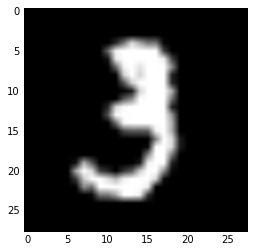

In [6]:
i = 10
print 'Label for image index {}: {}'.format(i, y_train[i])
print 'Image:'
plt.imshow(x_train[i][0], cmap=plt.cm.gray);

## Create the GAN model

In [7]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

### Generator

In [26]:
g_opt = Adam(lr=1e-4)

In [27]:
g_input = Input(shape=[100])
g = Dense(200*14*14, init='glorot_normal')(g_input)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Reshape([200, 14, 14])(g)
g = UpSampling2D(size=(2, 2))(g)

g = Convolution2D(100, 3, 3, border_mode='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Convolution2D(50, 3, 3, border_mode='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)

g = Convolution2D(1, 1, 1, border_mode='same', init='glorot_normal')(g)
g_output = Activation('sigmoid')(g)

generator = Model(g_input, g_output)
generator.compile(loss='binary_crossentropy', optimizer=g_opt)

In [28]:
# generator.summary()

### Discriminator

In [29]:
d_opt = Adam(lr=1e-3)

In [30]:
d_input = Input(shape=x_train.shape[1:])

d = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(d_input)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model(d_input, d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [31]:
# discriminator.summary()

### Stack Generator and Discriminator

In [32]:
make_trainable(discriminator, False)
# discriminator.trainable = False

In [33]:
gan_opt = Adam(lr=1e-4)

In [34]:
gan_input = Input(shape=[100])
g_output = generator(gan_input)
gan_output = discriminator(g_output)
gan = Model(gan_input, gan_output)
gan.compile(loss='categorical_crossentropy', optimizer=gan_opt)

In [35]:
# gan.summary()

## Train GAN

### Pre train Discriminator

In [36]:
# Sample real images
n = 10000
idx = np.random.randint(0, x_train.shape[0], size=n)
real_images = x_train[idx, :, :, :]

# Generate fake images
noise = np.random.uniform(0, 1, size=[n, 100])
fake_images = generator.predict(noise, verbose=0)

In [37]:
# Combine real and fake images
x = np.concatenate((real_images, fake_images))
y = np.zeros([2*n, 2])
y[:n, 1] = 1  # set second feature of y to 1 for real images
y[n:, 0] = 1  # set first feature of y to 1 for fake images

In [38]:
# Train the discriminator part of the network
make_trainable(discriminator, True)
# discriminator.trainable = True
discriminator.fit(x, y, nb_epoch=1, batch_size=32, verbose=2)

Epoch 1/1
31s - loss: 0.0078


In [39]:
# d_loss = discriminator.train_on_batch(x, y)
# print 'D loss: {}'.format(d_loss)

### Train

In [40]:
nb_epoch = 6000
batch_size = 32

In [41]:
import time
from IPython import display

Epoch 5980 out of 6000
D loss: 0.138249516487
GAN loss: 3.70660448074
Time elapsed in epoch 5980: 0.40 seconds


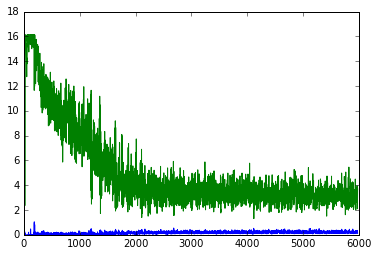

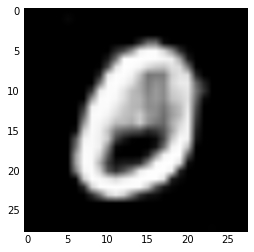

In [42]:
d_losses, gan_losses = [], []
for epoch in range(nb_epoch):
    start_time = time.time()
    # Sample real images
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    real_images = x_train[idx, :, :, :]
    
    # Generate fake images
    noise = np.random.uniform(0, 1, size=[batch_size, 100])
    fake_images = generator.predict(noise)
    
    # Combine real and fake images
    x = np.concatenate((real_images, fake_images))
    y = np.zeros([2*batch_size, 2])
    y[:batch_size, 1] = 1  # set second feature of y to 1 for real images
    y[batch_size:, 0] = 1  # set first feature of y to 1 for fake images
    
    # Train the discriminator part of the network
#     discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x, y)
    
    # Train the whole GAN network
    x = np.random.uniform(0, 1, size=[batch_size, 100])
    y = np.zeros([batch_size, 2])
    y[:, 1] = 1
#     discriminator.trainable = False
    gan_loss = gan.train_on_batch(x, y)
    d_losses += [d_loss]
    gan_losses += [gan_loss]
    
    if epoch % 20 == 0:  
        display.clear_output(wait=True)
        print 'Epoch {} out of {}'.format(epoch, nb_epoch)
        print 'D loss: {}'.format(d_loss)
        print 'GAN loss: {}'.format(gan_loss)
        print 'Time elapsed in epoch {}: {:.2f} seconds'.format(epoch, time.time()-start_time)
#         display.display(plt.gcf())
        plt.plot(d_losses);
        plt.plot(gan_losses);
        plt.legend();
        plt.show();
        
        # Sample real images
        n = 1
        idx = np.random.randint(0, x_train.shape[0], size=1)
        real_images = x_train[idx, :, :, :]

        # Generate fake images
        noise = np.random.uniform(0, 1, size=[1, 100])
        fake_images = generator.predict(noise, verbose=0)
        plt.imshow(fake_images[0][0], cmap=plt.cm.gray);
        plt.show();

## Test GAN

In [52]:
n = 5
noise = np.random.uniform(0, 1, size=[n, 100])
fake_images = generator.predict(noise, verbose=0)

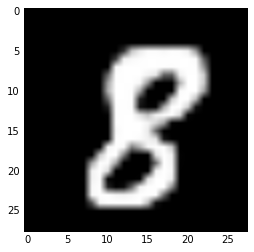

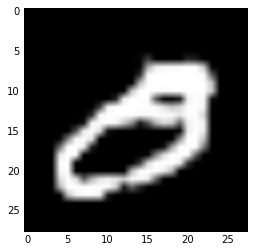

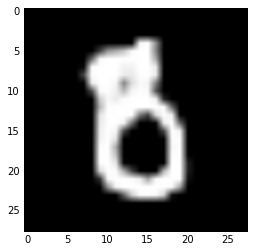

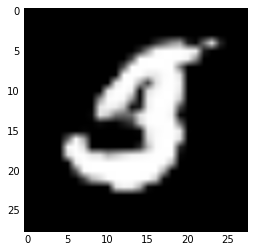

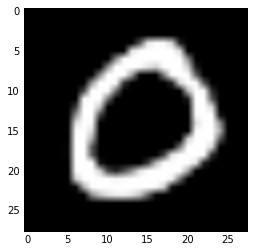

In [53]:
for img in fake_images:
    plt.figure()
    plt.imshow(img[0], cmap=plt.cm.gray);